In [1]:
import networkx as nx
import sys
sys.path.append(r'c:\\Users\\rotim\\OneDrive\\Documents\\Reading\\graph-code\\Skoltech-PhD-Thesis\\_codes\\SIR\\Influential-nodes-identification-in-complex-networks-via-information-entropy')
from algorithms import *
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import pickle

In [2]:
# data_file = 'HepPh'
# G = nx.read_adjlist(data_file)
# G.remove_edges_from(G.selfloop_edges())
# for node in nx.nodes(G):
#     if G.degree(node) == 0:
#         G.remove_node(node)

data_file = 'CEnew' # 'HepPh'
G = nx.read_adjlist(data_file)
G.remove_edges_from(nx.selfloop_edges(G))
nodes = list(nx.nodes(G))
for node in nodes:
    if G.degree(node) == 0:
        G.remove_node(node)

In [3]:
print(nx.number_of_nodes(G), nx.number_of_edges(G))

453 2025


In [5]:
max_ = 0.009
max_topk = round(max_ * nx.number_of_nodes(G))
print(max_topk)

degreerank = degree(G, max_topk)
print('done!')
degreerank_non = degree_non(G, max_topk)
print('done!')

# vote = voterank(G, max_topk)
# print('done!')
# vote_non = voterank_non(G, max_topk)
# print('done!')

newmethod_rank = EnRenewRank(G, max_topk, 2)
print('done!')

kshell_rank = kshell(G, max_topk)
print('done!')
kshell_rank_non = kshell_non(G, max_topk)
print('done!')

4
done!
done!
done!
done!
done!


## different lambda

In [6]:
infect_prob = compute_probability(G) * 1.5
avg = 100
max_iter = 200000
topk = round(max_ * nx.number_of_nodes(G))

degreerank_result = []
degreerank_non_result = []
vote_result = []
vote_non_result = []
newmethod_result = []
newmethod_non_result = []
kshell_result = []
kshell_non_result = []

for a in tqdm(range(10, 21, 2)):
    atio = a / 10
    cover_prob = infect_prob / atio
    degreerank_result.append(get_sir_result(G, degreerank, topk, avg, infect_prob, cover_prob, max_iter)[-1] / nx.number_of_nodes(G))
    degreerank_non_result.append(get_sir_result(G, degreerank_non, topk, avg, infect_prob, cover_prob, max_iter)[-1] / nx.number_of_nodes(G))
   # vote_result.append(get_sir_result(G, vote, topk, avg, infect_prob, cover_prob, max_iter)[-1] / nx.number_of_nodes(G))
   # vote_non_result.append(get_sir_result(G, vote_non, topk, avg, infect_prob, cover_prob, max_iter)[-1] / nx.number_of_nodes(G))
    newmethod_result.append(get_sir_result(G, newmethod_rank, topk, avg, infect_prob, cover_prob, max_iter)[-1] / nx.number_of_nodes(G))
    kshell_result.append(get_sir_result(G, kshell_rank, topk, avg, infect_prob, cover_prob, max_iter)[-1] / nx.number_of_nodes(G))
    kshell_non_result.append(get_sir_result(G, kshell_rank_non, topk, avg, infect_prob, cover_prob, max_iter)[-1] / nx.number_of_nodes(G))


100%|██████████| 6/6 [00:50<00:00,  8.38s/it]


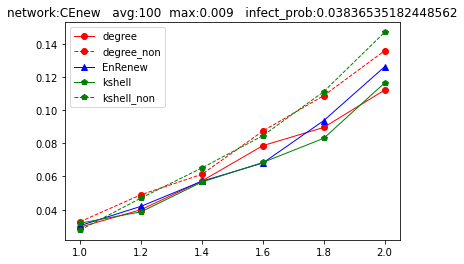

In [7]:
%matplotlib inline
plt.title('network:{}   avg:{}  max:{}   infect_prob:{}'.format(data_file, avg, max_, infect_prob))
plt.plot(np.array(range(10, 21, 2)) / 10, degreerank_result, 'r-o', label='degree', linewidth=1.0, )
plt.plot(np.array(range(10, 21, 2)) / 10, degreerank_non_result, 'r--o', label='degree_non', linewidth=1.0, )
# plt.plot(np.array(range(10, 21, 2)) / 10, vote_result, 'y-s', label='vote', linewidth=1.0, )
# plt.plot(np.array(range(10, 21, 2)) / 10, vote_non_result, 'y--s', label='vote_non', linewidth=1.0, )
plt.plot(np.array(range(10, 21, 2)) / 10, newmethod_result, 'b-^', label='EnRenew', linewidth=1.0, )
plt.plot(np.array(range(10, 21, 2)) / 10, kshell_result, 'g-p', label='kshell', linewidth=1.0, )
plt.plot(np.array(range(10, 21, 2)) / 10, kshell_non_result, 'g--p', label='kshell_non', linewidth=1.0, )
plt.legend()
plt.show()

In [8]:
infect_prob

0.03836535182448562

In [2]:
list(range(10, 21, 2))

[10, 12, 14, 16, 18, 20]

In [4]:
beta = [x/10 for x in list(range(10, 21, 2))]
beta

[1.0, 1.2, 1.4, 1.6, 1.8, 2.0]